# Yelp Analysis Model Stacking

By Zoe Cooper

In [208]:
#import statements
import pandas as pd
import numpy as np
import enchant
import pprint as pprint
import json
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from functools import partial
from json import JSONDecoder
from sklearn.model_selection import StratifiedKFold
from pprint import pprint
from sklearn.model_selection import train_test_split
import nltk
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
stemmer = SnowballStemmer("english")
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC #svm
ps = PorterStemmer()
from sklearn import preprocessing
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from vecstack import stacking
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier



In [209]:
def print_multiclass_classif_error_report(y_test, preds):
    print('Accuracy: ' + str(accuracy_score(y_test, preds)))
    print('Avg. F1 (Micro): ' + str(f1_score(y_test, preds, average='micro')))
    print('Avg. F1 (Macro): ' + str(f1_score(y_test, preds, average='macro')))
    print('Avg. F1 (Weighted): ' + str(f1_score(y_test, preds, average='weighted')))
    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n" + str(confusion_matrix(y_test, preds)))

Ensemble methods are an excellent way to improve predictive performance on your machine learning problems.
Stacked Generalization or stacking is an ensemble technique that uses a new model to learn how to best combine the predictions from two or more models trained on your dataset.
-meta learner

Its very difficult to distinguish between ratings varying by only 1 star. 

In [210]:
#read to file
file = []
for line in open("yelp_academic_dataset_review.json", 'r'):
    #data=json.load(f)
    file.append(json.loads(line))

In [211]:
#making dataframe
df = pd.DataFrame(file)

ones = df[df['stars'] == 1].sample(n=4000, random_state=1)
twos = df[df['stars'] == 2].sample(n=4000, random_state=1)
twees = df[df['stars'] == 3].sample(n=4000, random_state=1)
fours = df[df['stars'] == 4].sample(n=4000, random_state=1)
fives = df[df['stars'] == 5].sample(n=4000, random_state=1)

newdf = pd.concat([ones, twos, twees, fours, fives])


In [212]:
#dropping other columns:
olddata = df.drop(['business_id', 'date', 'review_id', 'type', 'user_id', 'votes'], axis=1)

In [213]:

#Defining preprocess function to clean up 'text' column:
def preprocess(raw_text):
    #remove punctuaction and put all lowercase
    text = raw_text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[0-9]+', '', text)
    text = text.lower()
    #tokenize into Unigrams
    wordlist = text.split() #turns string into list #could use word tokenize w/ nltk too
    #remove non-english words
    d = enchant.Dict("en_US")
    texts = []
    #stem words
    for word in wordlist:
        if d.check(word):
            texts.append(ps.stem(word))
    #remove stop words
    texts = [word for word in texts if word not in stopwords.words("english")]
    text = ' '.join(texts) #convert back to string
    return text

In [214]:
#setting y


y=newdf['stars']

print(y.unique())

[1 2 3 4 5]


In [215]:
#putting df column as corpus
raw_corpus = newdf['text']



In [216]:
#Preprocessing each review in corpus, above is function for that:
l = []
for review in raw_corpus:
    l.append(preprocess(review))


In [217]:
#dtm with pandas and sklearn
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(l)
df = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())
#print(df)

In [218]:
#tf-idf matrix
vec = TfidfVectorizer()
X = vec.fit_transform(l)
df2 = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())


In [219]:
x_train, x_test, y_train, y_test = train_test_split(df2,y,test_size=0.2) #20 percent is test set
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

16000
4000
16000
4000


The function below makes predictions on n-folds of train and test dataset. It returns the predictions for train and test for each model. This way we can use them with the next model.

In [220]:
#stacking function
def Stacking(model,train,y,test,n_fold):
    folds=StratifiedKFold(n_splits=n_fold,random_state=1)
    test_pred=np.empty((test.shape[0],1),int)
    train_pred=np.empty((0,1),int)
    for train_indices,val_indices in folds.split(train,y.values):
        x_train,x_val=train.iloc[train_indices],train.iloc[val_indices]
        y_train,y_val=y.iloc[train_indices],y.iloc[val_indices]
        model.fit(X=x_train,y=y_train)
        train_pred=np.append(train_pred,model.predict(x_val))
        test_pred=np.append(test_pred,model.predict(test))
    return test_pred,train_pred


Creating two base models – svc and kNN:

In [233]:
model1 = LinearSVC()


test_pred1 ,train_pred1=Stacking(model=model1,n_fold=10, train=x_train,test=x_test,y=y_train)

train_pred1=pd.DataFrame(train_pred1)
test_pred1=pd.DataFrame(test_pred1)




In [222]:
model2 = KNeighborsClassifier()
#XGBClassifier(random_state=1, n_jobs=-1, learning_rate=0.1, n_estimators=100, max_depth=3)

test_pred2 ,train_pred2=Stacking(model=model2,n_fold=10,train=x_train,test=x_test,y=y_train)

train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)


Making a third model, naive bayes, on the predictions of the svm and xgb models.

       0  0
0      1  1
1      2  1
2      5  1
3      1  1
4      4  1
5      5  1
6      4  4
7      5  1
8      3  4
9      4  1
10     5  4
11     2  1
12     4  1
13     5  1
14     5  1
15     3  4
16     1  1
17     3  1
18     4  4
19     5  1
20     3  1
21     5  1
22     3  1
23     2  4
24     3  4
25     2  4
26     4  4
27     5  1
28     5  1
29     1  1
...   .. ..
15970  5  4
15971  1  1
15972  4  1
15973  5  1
15974  2  1
15975  4  4
15976  5  1
15977  3  4
15978  3  4
15979  5  1
15980  5  4
15981  4  4
15982  3  1
15983  4  1
15984  1  1
15985  5  4
15986  4  4
15987  2  4
15988  3  1
15989  4  4
15990  3  1
15991  4  4
15992  5  3
15993  2  1
15994  5  1
15995  2  4
15996  5  1
15997  2  4
15998  5  1
15999  1  1

[16000 rows x 2 columns]
                     0        0
0                    0        0
1               668437   512021
2      140594454199710        0
3               817992   270613
4               153020  1117847
5               719988   455888
6     

ValueError: cannot copy sequence with size 785 to array axis with dimension 1

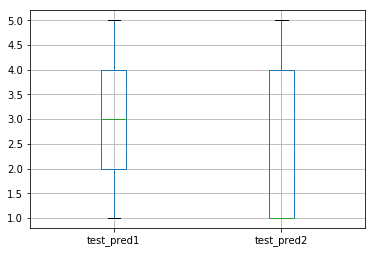

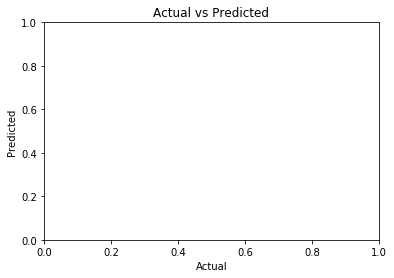

In [302]:

df = pd.concat([train_pred1, train_pred2], axis=1)
df_test = pd.concat([test_pred1, test_pred2], axis=1)

#model = LogisticRegression(random_state=1)
model = naive_bayes.GaussianNB()
model.fit(df,y_train)
#finaldftest = df_test[df_test.notnull()]

df_test = df_test.dropna()
print(df)
print(df_test)


print(y_test)
#dataframe = pd.merge([df_test, y_test])

print(len(df_test))
print(len(y_test))
print(model.score(df_test[40000:], y_test))




In [ ]:

df = df_test[40000:]
print(y_test)

df.columns = ['test_pred1', 'test_pred2']
print(df)

df.boxplot()

x = test_pred1[40000:]
print(x)
X = DataFrame(x)
X.columns = ['xstars']
print(X)
y = y_test
print(y)
Y = DataFrame(y)
Y.columns = ['ystars']
print(Y)

one = Y[Y['ystars'] == 1]
print(one); 

                            
two = Y[Y['ystars'] == 2]
print(two); 

three = Y[Y['ystars'] == 3]
print(three);

four = Y[Y['ystars'] == 4]
print(four);

five = Y[Y['ystars'] == 5]
print(five);

data = [one, two, three, four, five];

#make some plots

fig1, ax1 = plt.subplots();
ax1.set_title('Actual vs Predicted'); 
ax1.set_xlabel('Actual');
ax1.set_ylabel('Predicted');
ax1.boxplot(data);
plt.xticks([1, 2, 3, 4, 5], ["One Star", "Two Star", "Three Star", "Four Star", "Five Star"]);
plt.show();



Accuracy is a crude metric–there are of course finer-grained evaluation methods.It’s likely that some classes are ‘easier’ to predict than others, so we want to look at how well the classifier can predict each class (for example, only 5-star reviews) individually. Focus on precision and recall. We can measure both at the same time using an F1 Score, which measures both as a single metric. It seems like it's easiest to predict a '4' here.

With five rating classes, random guessing would be correct only 20% of the time. Next time... predicting a positive or negative review could be easier, more sentiment analysis with binary classification. Accuracy would probably be a lot higher. 

In [267]:
# Box and Whisker Plots



Empty DataFrame
Columns: [0, 0]
Index: []
Empty DataFrame
Columns: [0, 0]
Index: []


KeyError: '0'

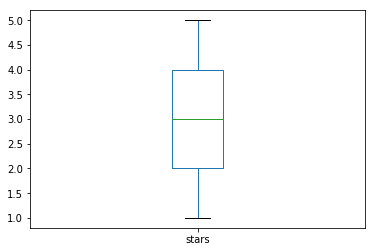